#### Importar librerías

In [86]:
import os
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import contextily as cx
from pathlib import Path
import numpy as np
import fiona

In [87]:
root_folder = r"C:\Users\sanac\Documents\UN\Programacion_SIG\Archivos"
shp_path = root_folder+"/municipios_colombia.shp"
csv_path = root_folder+"/Evaluaciones_Agropecuarias_Municipales_EVA.csv"
stations_csv_path = root_folder+"/Catalogo_Estaciones_IDEAM.csv"
road_path = root_folder+"/CBasica.gdb"
muni = gpd.read_file(shp_path)
eva = pd.read_csv(csv_path, encoding ='utf-8')
estac = pd.read_csv(stations_csv_path, encoding ='utf-8')

In [88]:
print(fiona.listlayers(road_path))

['Via', 'Puente_L', 'Puente_P', 'Tunel', 'VFerre', 'LVia', 'SVial', 'T_1_DirtyAreas', 'T_1_PointErrors', 'T_1_LineErrors', 'T_1_PolyErrors']


In [89]:
roads = gpd.read_file(road_path, layer="Via")

In [90]:
print(roads.columns)
print(roads.head())
print(roads["VTipo"].unique())
roads = roads.to_crs(epsg=9377)
print("CRS muni:", roads.crs)

Index(['VIdentifi', 'VTipo', 'VEstado', 'VCarril', 'VAcceso', 'SHAPE_Length',
       'RuleID', 'Override', 'geometry'],
      dtype='object')
  VIdentifi  VTipo VEstado VCarril VAcceso  SHAPE_Length  RuleID Override  \
0      None      1    3301    3501       1  12653.163260       1     None   
1      None      1    3301    3501       1    299.705614       1     None   
2      None      1    3301    3501       1  40043.323887       1     None   
3      None      1    3301    3501       1   1243.421210       1     None   
4      None      1    3301    3501       1  12354.058156       1     None   

                                            geometry  
0  MULTILINESTRING ((4931953.929 2019745.827, 493...  
1  MULTILINESTRING ((4973542.236 1968082.723, 497...  
2  MULTILINESTRING ((4931410.728 1940091.645, 493...  
3  MULTILINESTRING ((4958931.023 1920359.389, 495...  
4  MULTILINESTRING ((4950963.332 1927874.323, 495...  
[1 2 3 4 5 6 7 8]
CRS muni: EPSG:9377


In [91]:
muni = muni.to_crs(epsg=9377)
print("CRS muni:", muni.crs)

CRS muni: EPSG:9377


In [92]:
estac[['Latitud', 'Longitud']] = estac['Ubicación'].apply(lambda x: pd.Series(eval(x)))
estac_gpd = gpd.GeoDataFrame(
    estac,
    geometry = gpd.points_from_xy(estac['Longitud'], estac['Latitud']),
    crs="EPSG:4326"
)
estac_gpd = estac_gpd.to_crs(epsg=9377)
print("CRS estaciones:", estac_gpd.crs)
print(estac_gpd.head())

CRS estaciones: EPSG:9377
     Codigo                          Nombre            Categoria  Estado  \
0  52057100      RUMICHACA - AUT [52057100]         Limnigráfica  Activa   
1  52055170    LA JOSEFINA - AUT [52055170]  Climática Principal  Activa   
2  52055220     EL PARAISO - AUT [52055220]  Climática Principal  Activa   
3  44015070      EL PEPINO - AUT [44015070]  Climática Principal  Activa   
4  48015040  PUERTO NARINO - AUT [48015040]  Climática Principal  Activa   

  Departamento      Municipio                    Ubicación  Altitud  \
0       Nariño        Ipiales   (0.81378611, -77.66197778)     2582   
1       Nariño      Contadero   (0.93030556, -77.49119444)     2450   
2       Nariño      Túquerres   (1.07061111, -77.63688889)     3120   
3     Putumayo          Mocoa   (1.08288889, -76.66711111)      760   
4     Amazonas  Puerto Nariño  (-3.78030556, -70.36263889)      158   

  Fecha_instalacion Fecha_suspension Corriente   Latitud   Longitud  \
0        2016-11-15

In [94]:
eva = eva.rename(columns={'CÓD. MUN.': 'MPIO_CDPMP'})
eva['MPIO_CDPMP'] = eva['MPIO_CDPMP'].astype(str).str.zfill(5)
muni['MPIO_CDPMP'] = muni['MPIO_CDPMP'].astype(str).str.zfill(5)
muni['DPTO_CCDGO'] = muni['DPTO_CCDGO'].astype(str).str.zfill(2)

In [95]:
boy_muni = muni[muni['DPTO_CCDGO'] == '15'].copy()

In [96]:
boy_muni.head()

,DPTO_CCDGO,MPIO_CCDGO,MPIO_CNMBR,MPIO_CDPMP,VERSION,AREA,LATITUD,LONGITUD,STCTNENCUE,STP3_1_SI,...,STP51_PRIM,STP51_SECU,STP51_SUPE,STP51_POST,STP51_13_E,STP51_99_E,Shape_Leng,Shape_Area,Codigo_Mun,geometry
637,15,001,TUNJA,15001,2018,11968.891815,5.518473,-73.378019,79594.0,0.0,...,35470.0,56563.0,43652.0,14337.0,3156.0,4044.0,0.572327,0.009766,15001,"POLYGON ((4959760.536 2172167.311, 4959767.787..."
638,15,022,ALMEIDA,15022,2018,5767.211917,4.954825,-73.388134,2649.0,0.0,...,796.0,514.0,83.0,18.0,88.0,16.0,0.348469,0.004702,15022,"POLYGON ((4959230.781 2111994.725, 4959364.580..."
639,15,047,AQUITANIA,15047,2018,94214.656272,5.437416,-72.871495,25311.0,0.0,...,6536.0,4629.0,669.0,77.0,837.0,106.0,1.800311,0.076844,15047,"POLYGON ((5026299.410 2181056.535, 5026366.975..."
640,15,051,ARCABUCO,15051,2018,13789.858803,5.749565,-73.438880,4414.0,0.0,...,2433.0,1913.0,461.0,66.0,178.0,28.0,0.752709,0.011257,15051,"POLYGON ((4944132.595 2203718.480, 4944172.143..."
641,15,087,BELÉN,15087,2018,16308.822003,6.005059,-72.893699,8167.0,0.0,...,3050.0,2581.0,781.0,103.0,289.0,59.0,0.629349,0.013315,15087,"POLYGON ((5009188.804 2230505.691, 5009166.938..."


In [97]:
type1_road = roads[roads['VTipo'] == 1]

In [98]:
type1_road.head()

,VIdentifi,VTipo,VEstado,VCarril,VAcceso,SHAPE_Length,RuleID,Override,geometry
0,None,1,3301,3501,1,12653.163260,1,None,"MULTILINESTRING ((4931953.929 2019745.827, 493..."
1,None,1,3301,3501,1,299.705614,1,None,"MULTILINESTRING ((4973542.236 1968082.723, 497..."
2,None,1,3301,3501,1,40043.323887,1,None,"MULTILINESTRING ((4931410.728 1940091.645, 493..."
3,None,1,3301,3501,1,1243.421210,1,None,"MULTILINESTRING ((4958931.023 1920359.389, 495..."
4,None,1,3301,3501,1,12354.058156,1,None,"MULTILINESTRING ((4950963.332 1927874.323, 495..."


In [99]:
roads1 = roads.buffer(1000)

In [100]:
boy_muni['Vias'] = boy_muni.geometry.intersects(roads1.unary_union)
print(boy_muni['Vias'].unique())
boy_muni.head()

[ True]


,DPTO_CCDGO,MPIO_CCDGO,MPIO_CNMBR,MPIO_CDPMP,VERSION,AREA,LATITUD,LONGITUD,STCTNENCUE,STP3_1_SI,...,STP51_SECU,STP51_SUPE,STP51_POST,STP51_13_E,STP51_99_E,Shape_Leng,Shape_Area,Codigo_Mun,geometry,Vias
637,15,001,TUNJA,15001,2018,11968.891815,5.518473,-73.378019,79594.0,0.0,...,56563.0,43652.0,14337.0,3156.0,4044.0,0.572327,0.009766,15001,"POLYGON ((4959760.536 2172167.311, 4959767.787...",True
638,15,022,ALMEIDA,15022,2018,5767.211917,4.954825,-73.388134,2649.0,0.0,...,514.0,83.0,18.0,88.0,16.0,0.348469,0.004702,15022,"POLYGON ((4959230.781 2111994.725, 4959364.580...",True
639,15,047,AQUITANIA,15047,2018,94214.656272,5.437416,-72.871495,25311.0,0.0,...,4629.0,669.0,77.0,837.0,106.0,1.800311,0.076844,15047,"POLYGON ((5026299.410 2181056.535, 5026366.975...",True
640,15,051,ARCABUCO,15051,2018,13789.858803,5.749565,-73.438880,4414.0,0.0,...,1913.0,461.0,66.0,178.0,28.0,0.752709,0.011257,15051,"POLYGON ((4944132.595 2203718.480, 4944172.143...",True
641,15,087,BELÉN,15087,2018,16308.822003,6.005059,-72.893699,8167.0,0.0,...,2581.0,781.0,103.0,289.0,59.0,0.629349,0.013315,15087,"POLYGON ((5009188.804 2230505.691, 5009166.938...",True


In [101]:
vias_boy_muni = gpd.overlay(roads, boy_muni , how = 'intersection')

In [102]:
vias_boy_muni['long_via (km)'] = vias_boy_muni.geometry.length/1000
densidad_vias = vias_boy_muni.groupby('MPIO_CDPMP')['long_via (km)'].sum().reset_index()
densidad_vias.head()

,MPIO_CDPMP,long_via (km)
0,15001,236.594781
1,15022,85.078714
2,15047,513.415217
3,15051,118.869828
4,15087,213.348064


In [103]:
boy_muni['Area (km2)'] = boy_muni.geometry.area / 1e6

In [104]:
boy_muni = boy_muni.drop(columns=['long_via (km)'], errors = 'ignore')  # Elimina si existe
boy_muni = boy_muni.merge(densidad_vias, on = 'MPIO_CDPMP', how = 'left')
boy_muni['Densidad_vial'] = boy_muni['long_via (km)'] / boy_muni['Area (km2)']
boy_muni.head()

,DPTO_CCDGO,MPIO_CCDGO,MPIO_CNMBR,MPIO_CDPMP,VERSION,AREA,LATITUD,LONGITUD,STCTNENCUE,STP3_1_SI,...,STP51_13_E,STP51_99_E,Shape_Leng,Shape_Area,Codigo_Mun,geometry,Vias,Area (km2),long_via (km),Densidad_vial
0,15,001,TUNJA,15001,2018,11968.891815,5.518473,-73.378019,79594.0,0.0,...,3156.0,4044.0,0.572327,0.009766,15001,"POLYGON ((4959760.536 2172167.311, 4959767.787...",True,119.484917,236.594781,1.980123
1,15,022,ALMEIDA,15022,2018,5767.211917,4.954825,-73.388134,2649.0,0.0,...,88.0,16.0,0.348469,0.004702,15022,"POLYGON ((4959230.781 2111994.725, 4959364.580...",True,57.574192,85.078714,1.477723
2,15,047,AQUITANIA,15047,2018,94214.656272,5.437416,-72.871495,25311.0,0.0,...,837.0,106.0,1.800311,0.076844,15047,"POLYGON ((5026299.410 2181056.535, 5026366.975...",True,940.228755,513.415217,0.546054
3,15,051,ARCABUCO,15051,2018,13789.858803,5.749565,-73.438880,4414.0,0.0,...,178.0,28.0,0.752709,0.011257,15051,"POLYGON ((4944132.595 2203718.480, 4944172.143...",True,137.669042,118.869828,0.863446
4,15,087,BELÉN,15087,2018,16308.822003,6.005059,-72.893699,8167.0,0.0,...,289.0,59.0,0.629349,0.013315,15087,"POLYGON ((5009188.804 2230505.691, 5009166.938...",True,162.758743,213.348064,1.310824


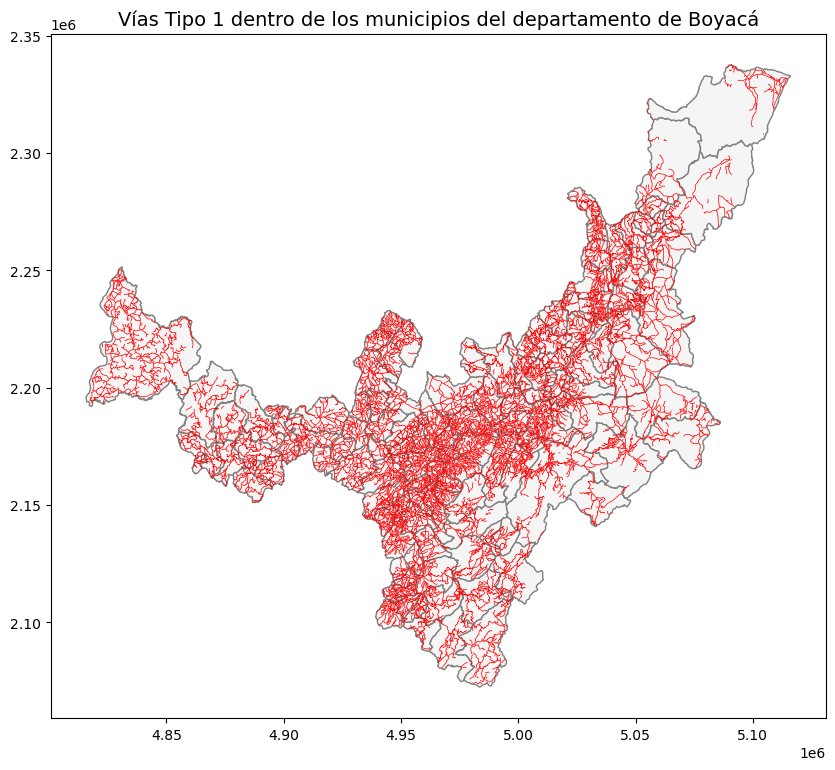

In [105]:
fig, ax = plt.subplots(figsize=(10, 10))
boy_muni.plot(ax=ax, color='whitesmoke', edgecolor='gray')
vias_boy_muni.plot(ax=ax, color='red', linewidth=0.5)

ax.set_title("Vías Tipo 1 dentro de los municipios del departamento de Boyacá", fontsize=14)

plt.show()

In [106]:
top20 = boy_muni.sort_values(by='Densidad_vial', ascending=False).head(20)
top20.head(20)

,DPTO_CCDGO,MPIO_CCDGO,MPIO_CNMBR,MPIO_CDPMP,VERSION,AREA,LATITUD,LONGITUD,STCTNENCUE,STP3_1_SI,...,STP51_13_E,STP51_99_E,Shape_Leng,Shape_Area,Codigo_Mun,geometry,Vias,Area (km2),long_via (km),Densidad_vial
102,15,764,SORACÁ,15764,2018,5575.775305,5.494890,-73.319000,4971.0,0.0,...,307.0,28.0,0.351033,0.004549,15764,"POLYGON ((4965278.967 2170513.321, 4965345.451...",True,55.660566,141.319622,2.538954
19,15,187,CHIVATÁ,15187,2018,4953.234015,5.563881,-73.263316,2885.0,0.0,...,143.0,29.0,0.425267,0.004042,15187,"POLYGON ((4974726.124 2180639.485, 4974739.359...",True,49.444204,113.624606,2.298037
105,15,778,SUTATENZA,15778,2018,4112.701065,5.026857,-73.433511,5753.0,0.0,...,244.0,19.0,0.307707,0.003353,15778,"POLYGON ((4953645.236 2116693.640, 4953669.428...",True,41.058400,93.197480,2.269876
69,15,494,NUEVO COLÓN,15494,2018,5139.679736,5.354701,-73.448734,5503.0,0.0,...,240.0,26.0,0.357776,0.004193,15494,"POLYGON ((4951729.044 2156394.206, 4951733.106...",True,51.311569,116.223988,2.265064
8,15,104,BOYACÁ,15104,2018,4802.286793,5.439856,-73.381370,6267.0,0.0,...,326.0,168.0,0.325614,0.003918,15104,"POLYGON ((4961459.911 2162891.490, 4961535.308...",True,47.941120,107.439417,2.241070
70,15,500,OICATÁ,15500,2018,6030.217623,5.610788,-73.279919,3363.0,0.0,...,123.0,19.0,0.337625,0.004921,15500,"POLYGON ((4970775.951 2183588.522, 4970795.111...",True,60.195532,133.693922,2.220994
117,15,835,TURMEQUÉ,15835,2018,7970.660437,5.305697,-73.509087,8282.0,0.0,...,339.0,47.0,0.388321,0.006502,15835,"POLYGON ((4947095.955 2151329.695, 4947079.386...",True,79.577578,175.194666,2.201558
118,15,837,TUTA,15837,2018,16533.038307,5.672127,-73.182982,7494.0,0.0,...,243.0,67.0,0.705995,0.013493,15837,"POLYGON ((4979498.797 2190049.252, 4979547.779...",True,165.027534,348.375085,2.111012
41,15,224,CUCAITA,15224,2018,4212.806645,5.527104,-73.445986,2762.0,0.0,...,89.0,25.0,0.291959,0.003438,15224,"POLYGON ((4952644.846 2172796.395, 4952658.155...",True,42.058134,87.900709,2.089981
100,15,762,SORA,15762,2018,4784.502378,5.580573,-73.443718,2476.0,0.0,...,123.0,19.0,0.299867,0.003905,15762,"POLYGON ((4954577.862 2178558.118, 4954585.520...",True,47.765530,96.584835,2.022061


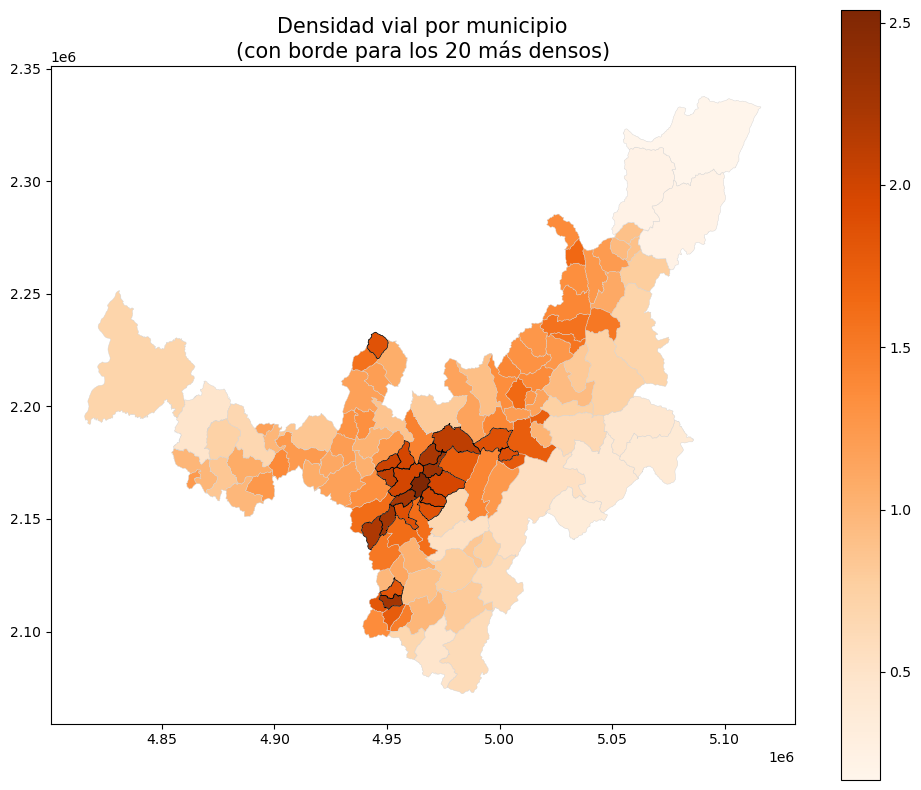

In [107]:
fig, ax = plt.subplots(1, 1, figsize=(12, 10))

# Coropletas: todos los municipios según su densidad vial
boy_muni.plot(column='Densidad_vial',
               cmap='Oranges',
               linewidth=0.3,
               edgecolor='lightgray',
               legend=True,
               ax=ax)

top20.boundary.plot(ax=ax, edgecolor='black', linewidth=0.5)

ax.set_title('Densidad vial por municipio\n(con borde para los 20 más densos)', fontsize=15)

plt.show()

In [108]:
esta_join = gpd.sjoin(estac_gpd, boy_muni, how="left", predicate="within")
conteo_est = esta_join.groupby("MPIO_CDPMP").size().reset_index(name="N_estaciones")

if "N_estaciones" in boy_muni.columns:
    boy_muni = boy_muni.drop(columns=["N_estaciones"])
    
boy_muni = boy_muni.merge(conteo_est, on="MPIO_CDPMP", how="left")
boy_muni["N_estaciones"] = boy_muni["N_estaciones"].fillna(0).astype(int)

boy_muni.head()

,DPTO_CCDGO,MPIO_CCDGO,MPIO_CNMBR,MPIO_CDPMP,VERSION,AREA,LATITUD,LONGITUD,STCTNENCUE,STP3_1_SI,...,STP51_99_E,Shape_Leng,Shape_Area,Codigo_Mun,geometry,Vias,Area (km2),long_via (km),Densidad_vial,N_estaciones
0,15,001,TUNJA,15001,2018,11968.891815,5.518473,-73.378019,79594.0,0.0,...,4044.0,0.572327,0.009766,15001,"POLYGON ((4959760.536 2172167.311, 4959767.787...",True,119.484917,236.594781,1.980123,5
1,15,022,ALMEIDA,15022,2018,5767.211917,4.954825,-73.388134,2649.0,0.0,...,16.0,0.348469,0.004702,15022,"POLYGON ((4959230.781 2111994.725, 4959364.580...",True,57.574192,85.078714,1.477723,4
2,15,047,AQUITANIA,15047,2018,94214.656272,5.437416,-72.871495,25311.0,0.0,...,106.0,1.800311,0.076844,15047,"POLYGON ((5026299.410 2181056.535, 5026366.975...",True,940.228755,513.415217,0.546054,37
3,15,051,ARCABUCO,15051,2018,13789.858803,5.749565,-73.438880,4414.0,0.0,...,28.0,0.752709,0.011257,15051,"POLYGON ((4944132.595 2203718.480, 4944172.143...",True,137.669042,118.869828,0.863446,2
4,15,087,BELÉN,15087,2018,16308.822003,6.005059,-72.893699,8167.0,0.0,...,59.0,0.629349,0.013315,15087,"POLYGON ((5009188.804 2230505.691, 5009166.938...",True,162.758743,213.348064,1.310824,1


In [109]:
top20_estac = boy_muni.sort_values(by='N_estaciones', ascending=False).head(20)
top20_estac.head(20)

top20_estaciones = gpd.sjoin(estac_gpd, top20_estac, how="inner", predicate="within")

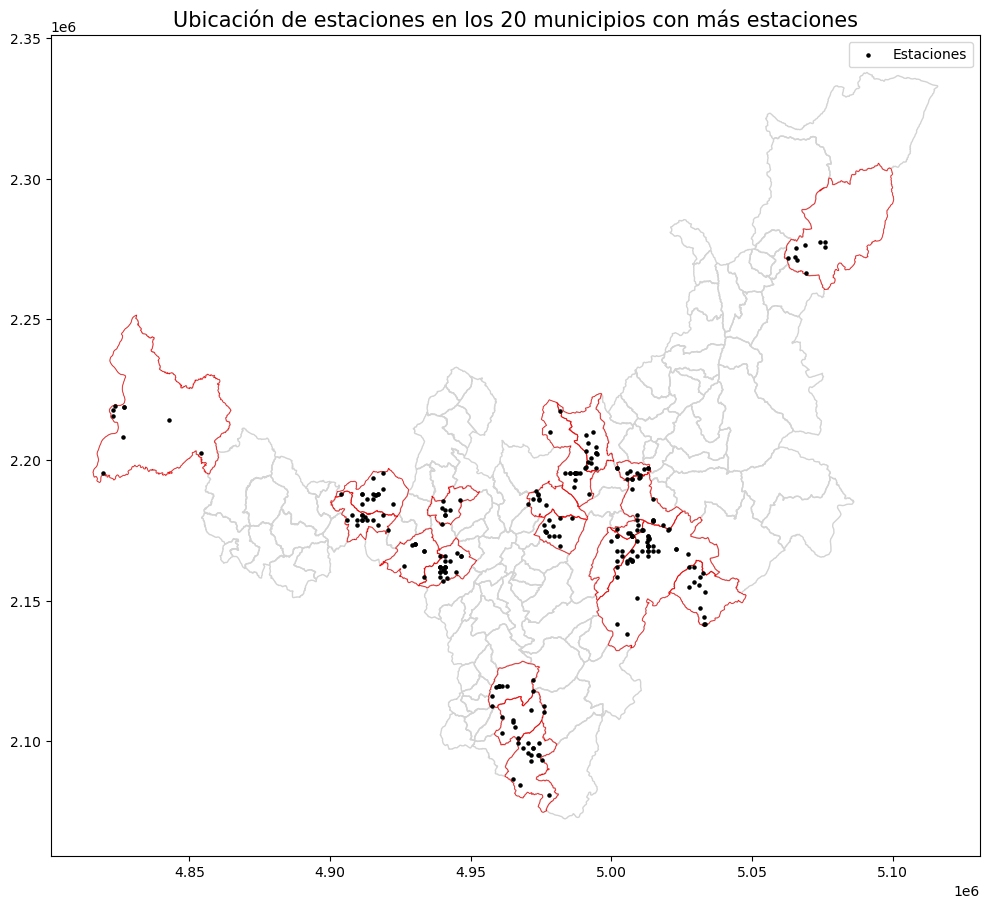

In [110]:
fig, ax = plt.subplots(figsize=(10, 10))
boy_muni.plot(ax=ax, facecolor='none', edgecolor='lightgray')
top20_estac.plot(ax=ax, facecolor="none", edgecolor="red", linewidth=0.5)
top20_estaciones.plot(ax=ax, color="black", markersize=5, label="Estaciones")

ax.set_title("Ubicación de estaciones en los 20 municipios con más estaciones", fontsize=15)
ax.legend()

plt.tight_layout()
plt.show()

In [111]:
print(eva.columns)
print(eva["DEPARTAMENTO"].unique())

Index(['CÓD. \nDEP.', 'DEPARTAMENTO', 'MPIO_CDPMP', 'MUNICIPIO',
       'GRUPO \nDE CULTIVO', 'SUBGRUPO \nDE CULTIVO', 'CULTIVO',
       'DESAGREGACIÓN REGIONAL Y/O SISTEMA PRODUCTIVO', 'AÑO', 'PERIODO',
       'Área Sembrada\n(ha)', 'Área Cosechada\n(ha)', 'Producción\n(t)',
       'Rendimiento\n(t/ha)', 'ESTADO FISICO PRODUCCION',
       'NOMBRE \nCIENTIFICO', 'CICLO DE CULTIVO'],
      dtype='object')
['BOYACA' 'CUNDINAMARCA' 'NORTE DE SANTANDER' 'SANTANDER' 'CAUCA'
 'VALLE DEL CAUCA' 'CALDAS' 'PUTUMAYO' 'TOLIMA' 'NARIÑO' 'QUINDIO'
 'ANTIOQUIA' 'CAQUETA' 'AMAZONAS' 'CHOCO' 'HUILA' 'ARAUCA' 'CASANARE'
 'LA GUAJIRA' 'BOLIVAR' 'CESAR' 'META' 'RISARALDA' 'SUCRE' 'CORDOBA'
 'VICHADA' 'MAGDALENA' 'GUAINIA' 'ATLANTICO' 'SAN ANDRES Y PROVIDENCIA'
 'GUAVIARE' 'VAUPES']


In [113]:
papa_boy = (
    eva.query('CULTIVO == "PAPA" and AÑO == 2017 and DEPARTAMENTO == "BOYACA"')
    .copy()
)
papa_boy['Rendimiento (ton/ha)'] = (papa_boy['Producción\n(t)'] / papa_boy['Área Sembrada\n(ha)'])

papa_agrupado = papa_boy.groupby(['MPIO_CDPMP','MUNICIPIO']).agg({
    'Producción\n(t)': 'sum',
    'Área Sembrada\n(ha)': 'sum',
    'Rendimiento (ton/ha)': 'sum'
}).reset_index()

papa_agrupado.head()

,MPIO_CDPMP,MUNICIPIO,Producción\n(t),Área Sembrada\n(ha),Rendimiento (ton/ha)
0,15001,TUNJA,77600,3975,60.000000
1,15022,ALMEIDA,46,9,9.900000
2,15047,AQUITANIA,8831,425,58.078571
3,15051,ARCABUCO,45000,2700,33.351724
4,15087,BELEN,29248,1542,63.360957


In [114]:
boy_muni = boy_muni.merge(papa_agrupado, on="MPIO_CDPMP", how="left")
boy_muni.head()

,DPTO_CCDGO,MPIO_CCDGO,MPIO_CNMBR,MPIO_CDPMP,VERSION,AREA,LATITUD,LONGITUD,STCTNENCUE,STP3_1_SI,...,geometry,Vias,Area (km2),long_via (km),Densidad_vial,N_estaciones,MUNICIPIO,Producción\n(t),Área Sembrada\n(ha),Rendimiento (ton/ha)
0,15,001,TUNJA,15001,2018,11968.891815,5.518473,-73.378019,79594.0,0.0,...,"POLYGON ((4959760.536 2172167.311, 4959767.787...",True,119.484917,236.594781,1.980123,5,TUNJA,77600.0,3975.0,60.000000
1,15,022,ALMEIDA,15022,2018,5767.211917,4.954825,-73.388134,2649.0,0.0,...,"POLYGON ((4959230.781 2111994.725, 4959364.580...",True,57.574192,85.078714,1.477723,4,ALMEIDA,46.0,9.0,9.900000
2,15,047,AQUITANIA,15047,2018,94214.656272,5.437416,-72.871495,25311.0,0.0,...,"POLYGON ((5026299.410 2181056.535, 5026366.975...",True,940.228755,513.415217,0.546054,37,AQUITANIA,8831.0,425.0,58.078571
3,15,051,ARCABUCO,15051,2018,13789.858803,5.749565,-73.438880,4414.0,0.0,...,"POLYGON ((4944132.595 2203718.480, 4944172.143...",True,137.669042,118.869828,0.863446,2,ARCABUCO,45000.0,2700.0,33.351724
4,15,087,BELÉN,15087,2018,16308.822003,6.005059,-72.893699,8167.0,0.0,...,"POLYGON ((5009188.804 2230505.691, 5009166.938...",True,162.758743,213.348064,1.310824,1,BELEN,29248.0,1542.0,63.360957


In [ ]:
boy_muni['Vias%'] = boy_muni.geometry.intersects(roads1.unary_union)*1